In [2]:
!pip install nltk
!pip install datasets

In [3]:
import os
import datasets
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import nltk
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

nltk.download('punkt')
nltk.download('punkt_tab')
torch.manual_seed(1)

[nltk_data] Downloading package punkt to /Users/yawen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/yawen/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# Load the dataset. This is a sentiment analysis of financial texts.
data_pd = pd.read_csv('FinancialPhraseBank.csv', index_col=0)
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4846 non-null   object
 1   label   4846 non-null   object
dtypes: object(2)
memory usage: 113.6+ KB


In [5]:
data_pd.head()

,text,label
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


In [6]:
import nltk
import re
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')  # Download the stopwords data from NLTK
stops = stopwords.words("english")  # Store the list of English stopwords, which will be removed during preprocessing

## Check if a string contains any digits
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))

## Regular expressions are a tool for describing and matching string patterns.
## They allow you to define a pattern and search for parts of the text that match it.
## For example: \d means any digit, \w means a letter, digit, or underscore.

## Function to preprocess text
def preprocess_txt_data(txt):
    ## Convert all characters to lowercase
    txt_lower = txt.lower()
    
    ## Remove all symbols and punctuation
    txt_lower = re.sub(r'[^\w\s]', '', txt_lower)  # Removes all non-alphanumeric and non-whitespace characters
    
    ## Tokenize the text into individual words
    all_words = word_tokenize(txt_lower)  # Split the cleaned text into tokens using word_tokenize

    cleaned_words = []
    for word in all_words:
        ## Remove stopwords and words containing digits
        if (word in stops) or (hasNumbers(word)):
            continue
        cleaned_words.append(word)
    
    return ' '.join(cleaned_words)

## Map sentiment labels to numeric values
label_map_dict = {'neutral': 0, 'negative': 1, 'positive': 2}

[nltk_data] Downloading package stopwords to /Users/yawen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
data_pd['cleaned_text'] = data_pd['text'].apply(lambda x: preprocess_txt_data(x))
data_pd['cleaned_label'] = data_pd['label'].apply(lambda x: label_map_dict[x])

In [8]:
data_pd.head()

,text,label,cleaned_text,cleaned_label
0,"According to Gran , the company has no plans t...",neutral,according gran company plans move production r...,0
1,Technopolis plans to develop in stages an area...,neutral,technopolis plans develop stages area less squ...,0
2,The international electronic industry company ...,negative,international electronic industry company elco...,1
3,With the new production plant the company woul...,positive,new production plant company would increase ca...,2
4,According to the company 's updated strategy f...,positive,according company updated strategy years baswa...,2


In [9]:
## Build a task-specific vocabulary for this project, to be used for the word embedding module
all_words = []
for tmp_txt in data_pd['cleaned_text'].values:  # Use .values to access all text strings
    all_words += tmp_txt.split()  # Split each text string into a list of words and add them to all_words

alll = all_words  # Store all words (including duplicates)
all_unique_words = set(all_words)  # Convert the list to a set to remove duplicates and get all unique words

print("number of all:" , len(alll))
print('number of unique words: ', len(all_unique_words))

# Assign a unique index to each word
word_to_index = {}
idx = 0
for word in all_unique_words:
    word_to_index[word] = idx
    idx += 1

number of all: 57302
number of unique words:  9255


In [10]:
data_pd = data_pd[data_pd.cleaned_text.apply(lambda x: len(x) > 0)]  # Remove samples with no valid characters

## In this experiment, we use the first 2500 samples as the training set and the remaining samples as the validation set
train_data_pd = data_pd.iloc[:2500]
val_data_pd = data_pd.iloc[2500:]

In [11]:
## Define a custom Dataset class for model training
class text_dataset(Dataset):
    def __init__(self, text_data, target, word_to_index_dict):
        super(text_dataset, self).__init__()
        self.inputs_x = []
        for tmp_txt in text_data:
            index_list = [word_to_index_dict[d] for d in tmp_txt.split()]
            self.inputs_x.append(np.array(index_list))
        self.inputs_y = target

    def __getitem__(self, index):
        tmp_x = self.inputs_x[index]
        tmp_y = self.inputs_y[index]
        return tmp_x, tmp_y

    def __len__(self):
        return len(self.inputs_x)

In [12]:
train_dataset = text_dataset(train_data_pd['cleaned_text'].values, train_data_pd['cleaned_label'].values, word_to_index)
val_dataset = text_dataset(val_data_pd['cleaned_text'].values, val_data_pd['cleaned_label'].values, word_to_index)

# Since sentence lengths vary, the input shapes differ. Therefore, batch training is not applicable
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [13]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [14]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMClassifier, self).__init__()
        # The model includes a word embedding layer that learns vector representations for each word during training
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # The LSTM takes the word embeddings as input and outputs hidden states of dimension hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Apply a linear transformation to the LSTM output
        self.process_hidden = nn.Linear(hidden_dim, hidden_dim)
        # The final linear layer maps the hidden state space to the label space
        self.fc = nn.Linear(hidden_dim, tagset_size)  # classifier

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, (hideen_state, cell_state) = self.lstm(embeds)
        result = torch.tanh(self.process_hidden(lstm_out[:, -1, :]))  # Use the last hidden state for prediction
        result = self.fc(result)
        return result

In [15]:
N_EPOCHS = 10
EMBEDDING_DIM = 200
HIDDEN_DIM = 200
vocabulary_size = len(word_to_index)
number_of_class = len(label_map_dict)

In [16]:
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, vocabulary_size, number_of_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Initialize history dictionary
lstm_history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(N_EPOCHS):
    model.train()  # Set model to training mode
    train_loss = 0
    train_preds = []
    train_labels = []
    for sentence, label in train_dataloader:
        sentence, label = sentence.to(device), label.to(device)
        # Remember that PyTorch accumulates gradients. We need to zero them before each training instance
        model.zero_grad()
        # Forward pass
        outputs = model(sentence.long())
        # Compute loss and gradients, then update the model with optimizer.step()
        loss = criterion(outputs, label.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(label.cpu().numpy())

    model.eval()  # Set model to evaluation mode
    val_loss = 0
    all_preds = []  # Store predictions
    all_labels = []  # Store ground truth labels
    with torch.no_grad():
        for sentence, label in val_dataloader:
            sentence, label = sentence.to(device), label.to(device)
            outputs = model(sentence.long())
            loss = criterion(outputs, label.long())
            val_loss += loss.item()
            # Compute predicted class
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            
    # Record loss and accuracy
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_acc = accuracy_score(train_labels, train_preds)
    val_acc = accuracy_score(all_labels, all_preds)
    
    # Save to history
    lstm_history["train_loss"].append(train_loss)
    lstm_history["val_loss"].append(val_loss)
    lstm_history["train_acc"].append(train_acc)
    lstm_history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/10
Train Loss: 0.7879 | Train Acc: 0.5744 | Val Loss: 1.3790 | Val Acc: 0.3910
Epoch 2/10
Train Loss: 0.6034 | Train Acc: 0.7228 | Val Loss: 1.3520 | Val Acc: 0.5437
Epoch 3/10
Train Loss: 0.4110 | Train Acc: 0.8316 | Val Loss: 1.6415 | Val Acc: 0.5049
Epoch 4/10
Train Loss: 0.2341 | Train Acc: 0.9156 | Val Loss: 1.8819 | Val Acc: 0.5356
Epoch 5/10
Train Loss: 0.1066 | Train Acc: 0.9688 | Val Loss: 3.1542 | Val Acc: 0.3953
Epoch 6/10
Train Loss: 0.0657 | Train Acc: 0.9816 | Val Loss: 3.3286 | Val Acc: 0.4725
Epoch 7/10
Train Loss: 0.0406 | Train Acc: 0.9912 | Val Loss: 3.2314 | Val Acc: 0.4729
Epoch 8/10
Train Loss: 0.0344 | Train Acc: 0.9940 | Val Loss: 3.0153 | Val Acc: 0.5267
Epoch 9/10
Train Loss: 0.0368 | Train Acc: 0.9920 | Val Loss: 3.2641 | Val Acc: 0.5066
Epoch 10/10
Train Loss: 0.0343 | Train Acc: 0.9908 | Val Loss: 2.9909 | Val Acc: 0.5356


In [17]:
## In the following model, after converting words into word embeddings, 
## an attention module is applied to assign weights to each word vector, 
## resulting in a single sentence-level representation. This final vector is used for prediction.
class AttentionClassifier(nn.Module):
    def __init__(self, embedding_dim, vocab_size, tagset_size):
        super(AttentionClassifier, self).__init__()
        # The model includes a word embedding layer, which learns vector representations of words during training
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # The final linear layer maps the sentence vector to the label space
        self.fc = nn.Linear(embedding_dim, tagset_size)  # classifier
        self.w_d1 = nn.Linear(embedding_dim, embedding_dim)  # Transform word vectors first
        self.w_d2 = nn.Linear(embedding_dim, 1)  # Compute attention scores for each word

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        embeds_t = torch.tanh(self.w_d1(embeds))
        attention_score = torch.softmax(self.w_d2(embeds_t), dim=1)
        sentence_vector = torch.sum(attention_score * embeds_t, dim=1)
        result = self.fc(sentence_vector)  # Use the final sentence vector for prediction
        return result

In [18]:
model = AttentionClassifier(EMBEDDING_DIM, vocabulary_size, number_of_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

attn_history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(N_EPOCHS):
    model.train()  # Set model to training mode
    train_loss = 0
    train_preds = []
    train_labels = []
    for sentence, label in train_dataloader:
        sentence, label = sentence.to(device), label.to(device)
        # Note that PyTorch accumulates gradients. We need to clear them before each training instance
        model.zero_grad()
        # Forward pass
        outputs = model(sentence.long())
        # Compute loss and gradients, then update parameters with optimizer.step()
        loss = criterion(outputs, label.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(label.cpu().numpy())

    model.eval()  # Set model to evaluation mode
    val_loss = 0
    all_preds = []  # Store predicted labels
    all_labels = []  # Store corresponding ground truth labels
    with torch.no_grad():
        for sentence, label in val_dataloader:
            sentence, label = sentence.to(device), label.to(device)
            outputs = model(sentence.long())
            loss = criterion(outputs, label.long())
            val_loss += loss.item()
            # Get predicted class
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
    # Record loss and accuracy
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_acc = accuracy_score(train_labels, train_preds)
    val_acc = accuracy_score(all_labels, all_preds)

    attn_history["train_loss"].append(train_loss)
    attn_history["val_loss"].append(val_loss)
    attn_history["train_acc"].append(train_acc)
    attn_history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/10
Train Loss: 0.8332 | Train Acc: 0.5880 | Val Loss: 1.2389 | Val Acc: 0.5296
Epoch 2/10
Train Loss: 0.6701 | Train Acc: 0.6908 | Val Loss: 1.1934 | Val Acc: 0.5271
Epoch 3/10
Train Loss: 0.5958 | Train Acc: 0.7308 | Val Loss: 1.3073 | Val Acc: 0.5288
Epoch 4/10
Train Loss: 0.5399 | Train Acc: 0.7668 | Val Loss: 1.2861 | Val Acc: 0.5599
Epoch 5/10
Train Loss: 0.4920 | Train Acc: 0.7940 | Val Loss: 1.3553 | Val Acc: 0.5224
Epoch 6/10
Train Loss: 0.4516 | Train Acc: 0.8080 | Val Loss: 1.2995 | Val Acc: 0.5689
Epoch 7/10
Train Loss: 0.4126 | Train Acc: 0.8260 | Val Loss: 1.4150 | Val Acc: 0.5527
Epoch 8/10
Train Loss: 0.3764 | Train Acc: 0.8404 | Val Loss: 1.4291 | Val Acc: 0.5544
Epoch 9/10
Train Loss: 0.3404 | Train Acc: 0.8608 | Val Loss: 1.4900 | Val Acc: 0.5437
Epoch 10/10
Train Loss: 0.3054 | Train Acc: 0.8760 | Val Loss: 1.5871 | Val Acc: 0.5407


In [19]:
## Combine LSTM and Attention modules
class LSTMAttentionClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        # The model includes a word embedding layer, which learns vector representations of words during training
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # The LSTM takes the word embeddings as input and outputs hidden states of dimension hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Apply a linear transformation to the output of the LSTM
        self.process_hidden = nn.Linear(hidden_dim, hidden_dim)
        # The final linear layer maps the hidden state space to the label space
        self.fc = nn.Linear(hidden_dim, tagset_size)  # classifier
        self.w_d1 = nn.Linear(hidden_dim, hidden_dim)  # Transform the hidden states before attention
        self.w_d2 = nn.Linear(hidden_dim, 1)  # Compute attention weights for each hidden state

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, (hideen_state, cell_state) = self.lstm(embeds)
        ## Apply attention over all hidden states from the LSTM to generate a sentence representation
        lstm_out_t = torch.tanh(self.w_d1(lstm_out))
        attention_score = torch.softmax(self.w_d2(lstm_out_t), dim=1)
        sentence_vector = torch.sum(attention_score * lstm_out_t, dim=1)
        result = self.fc(sentence_vector)  # Use the final sentence vector for prediction
        return result

In [20]:
model = LSTMAttentionClassifier(EMBEDDING_DIM, HIDDEN_DIM, vocabulary_size, number_of_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

lstm_attn_history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(N_EPOCHS):
    model.train()  # Set model to training mode
    train_loss = 0
    train_preds = []
    train_labels = []
    for sentence, label in train_dataloader:
        sentence, label = sentence.to(device), label.to(device)
        # Note that PyTorch accumulates gradients. We need to clear them before each training instance
        model.zero_grad()
        # Forward pass
        outputs = model(sentence.long())
        # Compute loss and gradients, then update the model with optimizer.step()
        loss = criterion(outputs, label.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(label.cpu().numpy())

    model.eval()  # Set model to evaluation mode
    val_loss = 0
    all_preds = []  # Store predicted labels
    all_labels = []  # Store corresponding ground truth labels
    with torch.no_grad():
        for sentence, label in val_dataloader:
            sentence, label = sentence.to(device), label.to(device)
            outputs = model(sentence.long())
            loss = criterion(outputs, label.long())
            val_loss += loss.item()
            # Compute predicted class
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
    # Record loss and accuracy
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_acc = accuracy_score(train_labels, train_preds)
    val_acc = accuracy_score(all_labels, all_preds)

    lstm_attn_history["train_loss"].append(train_loss)
    lstm_attn_history["val_loss"].append(val_loss)
    lstm_attn_history["train_acc"].append(train_acc)
    lstm_attn_history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/10
Train Loss: 0.7656 | Train Acc: 0.6016 | Val Loss: 1.2235 | Val Acc: 0.5625
Epoch 2/10
Train Loss: 0.5800 | Train Acc: 0.7384 | Val Loss: 1.1604 | Val Acc: 0.5706
Epoch 3/10
Train Loss: 0.4303 | Train Acc: 0.8160 | Val Loss: 1.2792 | Val Acc: 0.5620
Epoch 4/10
Train Loss: 0.2701 | Train Acc: 0.8932 | Val Loss: 1.5066 | Val Acc: 0.5736
Epoch 5/10
Train Loss: 0.1583 | Train Acc: 0.9400 | Val Loss: 2.2457 | Val Acc: 0.4921
Epoch 6/10
Train Loss: 0.0872 | Train Acc: 0.9752 | Val Loss: 2.3833 | Val Acc: 0.5778
Epoch 7/10
Train Loss: 0.0549 | Train Acc: 0.9848 | Val Loss: 2.9675 | Val Acc: 0.5228
Epoch 8/10
Train Loss: 0.0511 | Train Acc: 0.9852 | Val Loss: 3.1648 | Val Acc: 0.5198
Epoch 9/10
Train Loss: 0.0423 | Train Acc: 0.9892 | Val Loss: 3.1290 | Val Acc: 0.5322
Epoch 10/10
Train Loss: 0.0307 | Train Acc: 0.9924 | Val Loss: 3.3423 | Val Acc: 0.5407


In [21]:
## Combine the Transformer Encoder module and an additional Attention module
class TransformerAttentionClassifier(nn.Module):
    def __init__(self, embedding_dim, vocab_size, tagset_size, max_seq_length=1000):
        super(TransformerAttentionClassifier, self).__init__()
        # The model includes a word embedding layer, which learns vector representations of words during training
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Add position embeddings (trainable)
        self.position_embeddings = nn.Embedding(max_seq_length, embedding_dim)
        self.encoder = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8)
        # Apply a linear transformation to the encoder output
        self.process_hidden = nn.Linear(embedding_dim, embedding_dim)
        # Final linear layer maps hidden states to the label space
        self.fc = nn.Linear(embedding_dim, tagset_size)  # classifier
        self.w_d1 = nn.Linear(embedding_dim, embedding_dim)  # Transform word vectors before computing attention
        self.w_d2 = nn.Linear(embedding_dim, 1)  # Compute attention weights for each token

    def forward(self, sentence):
        word_embeds = self.word_embeddings(sentence)
        # Generate position IDs (automatically adapted to input length)
        positions = torch.arange(0, sentence.size(1), dtype=torch.long, device=sentence.device)
        positions = positions.unsqueeze(0).expand_as(sentence)  # (batch_size, seq_len)
        # Add position embeddings
        pos_embeds = self.position_embeddings(positions)  # (batch_size, seq_len, embedding_dim)
        embeds = word_embeds + pos_embeds

        encoder_output = self.encoder(embeds)
        ## Apply attention to all encoder outputs to compute the final sentence vector
        encoder_output_t = torch.tanh(self.w_d1(encoder_output))
        attention_score = torch.softmax(self.w_d2(encoder_output_t), dim=1)
        sentence_vector = torch.sum(attention_score * encoder_output_t, dim=1)
        result = self.fc(sentence_vector)  # Use the sentence vector for final prediction
        return result

In [22]:
model = TransformerAttentionClassifier(EMBEDDING_DIM, vocabulary_size, number_of_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

transformer_history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(N_EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0
    train_preds = []
    train_labels = []
    for sentence, label in train_dataloader:
        sentence, label = sentence.to(device), label.to(device)
        # Note that PyTorch accumulates gradients. We need to clear them before each training instance
        model.zero_grad()
        # Forward pass
        outputs = model(sentence.long())
        # Compute loss and gradients, then update parameters
        loss = criterion(outputs, label.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(label.cpu().numpy())

    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    all_preds = []  # Store predictions
    all_labels = []  # Store true labels
    with torch.no_grad():
        for sentence, label in val_dataloader:
            sentence, label = sentence.to(device), label.to(device)
            outputs = model(sentence.long())
            loss = criterion(outputs, label.long())
            val_loss += loss.item()
            # Get predicted class
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
    # Record loss and accuracy
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_acc = accuracy_score(train_labels, train_preds)
    val_acc = accuracy_score(all_labels, all_preds)

    transformer_history["train_loss"].append(train_loss)
    transformer_history["val_loss"].append(val_loss)
    transformer_history["train_acc"].append(train_acc)
    transformer_history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/10
Train Loss: 0.7716 | Train Acc: 0.5696 | Val Loss: 1.2087 | Val Acc: 0.4439
Epoch 2/10
Train Loss: 0.6924 | Train Acc: 0.6640 | Val Loss: 1.3124 | Val Acc: 0.5454
Epoch 3/10
Train Loss: 0.6170 | Train Acc: 0.7140 | Val Loss: 1.4480 | Val Acc: 0.5369
Epoch 4/10
Train Loss: 0.5284 | Train Acc: 0.7764 | Val Loss: 1.5171 | Val Acc: 0.3638
Epoch 5/10
Train Loss: 0.4509 | Train Acc: 0.8124 | Val Loss: 1.5863 | Val Acc: 0.4290
Epoch 6/10
Train Loss: 0.3575 | Train Acc: 0.8564 | Val Loss: 1.5879 | Val Acc: 0.5915
Epoch 7/10
Train Loss: 0.2799 | Train Acc: 0.8912 | Val Loss: 1.8898 | Val Acc: 0.4887
Epoch 8/10
Train Loss: 0.2154 | Train Acc: 0.9184 | Val Loss: 1.9426 | Val Acc: 0.4942
Epoch 9/10
Train Loss: 0.1605 | Train Acc: 0.9456 | Val Loss: 2.0037 | Val Acc: 0.6030
Epoch 10/10
Train Loss: 0.1268 | Train Acc: 0.9540 | Val Loss: 2.3901 | Val Acc: 0.5343


In [23]:
import matplotlib.pyplot as plt

def plot_single_model_history(name, history):
    epochs = range(len(history["train_loss"]))
    
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{name} - Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.plot(epochs, history["train_acc"], label="Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{name} - Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

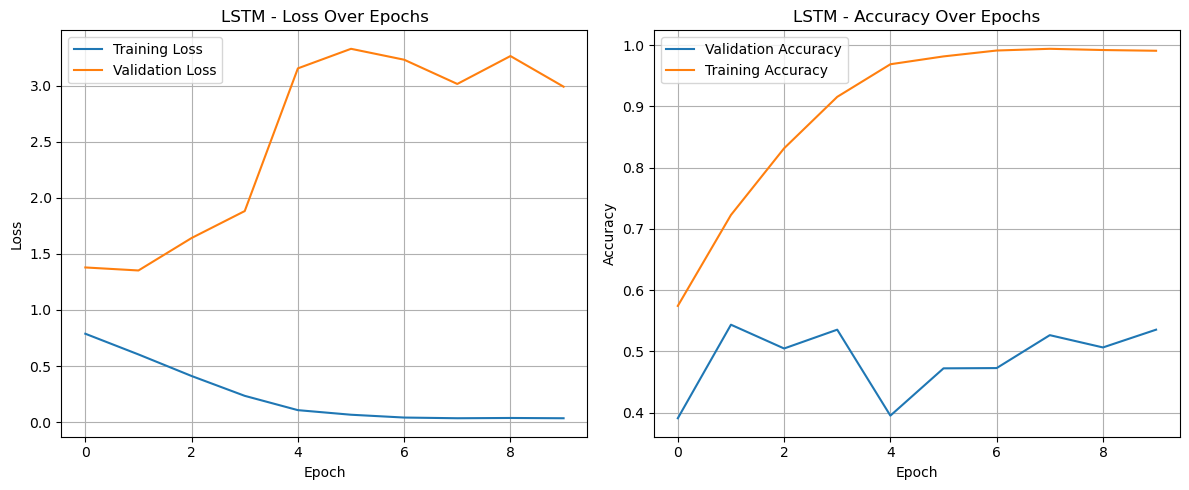

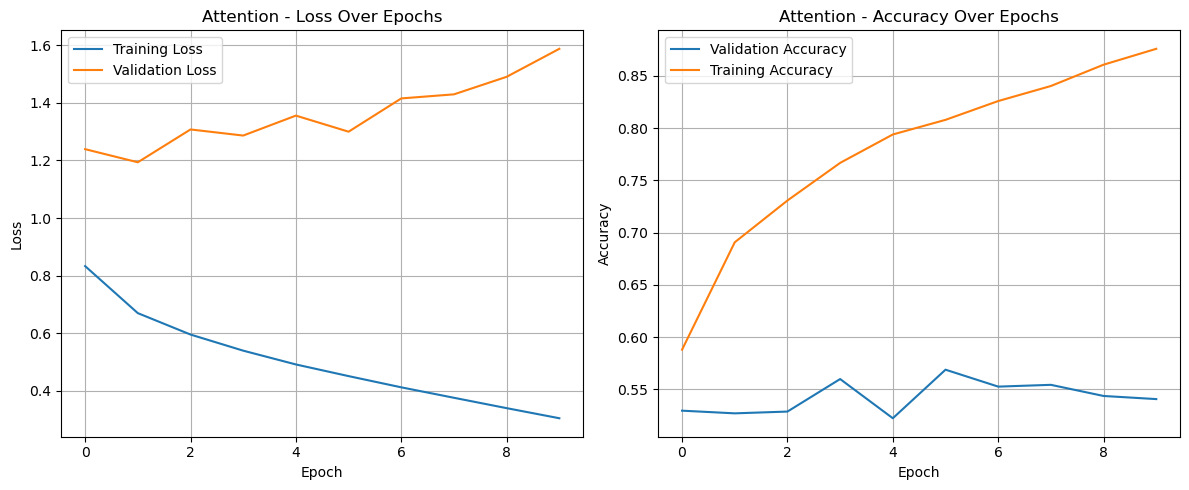

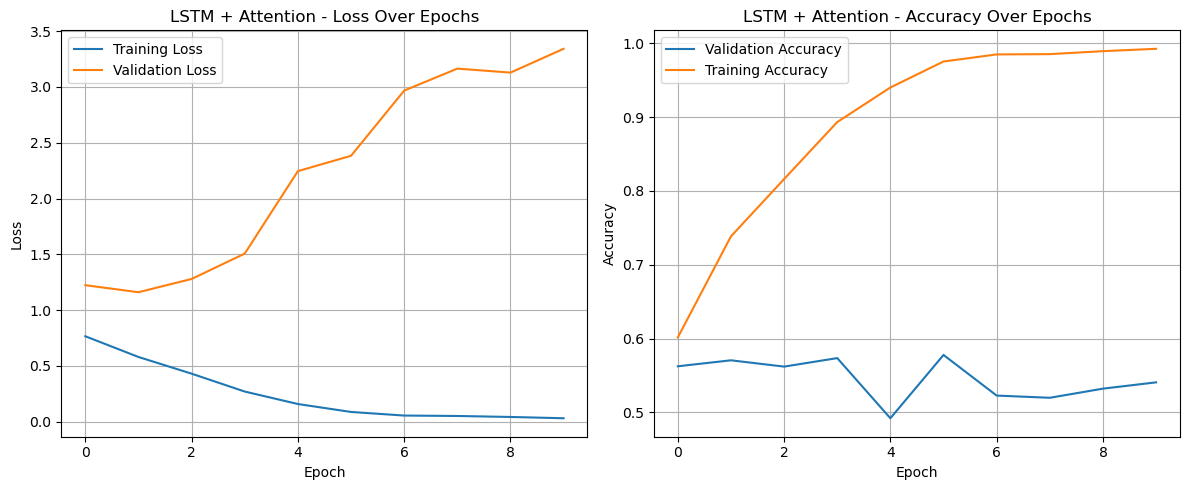

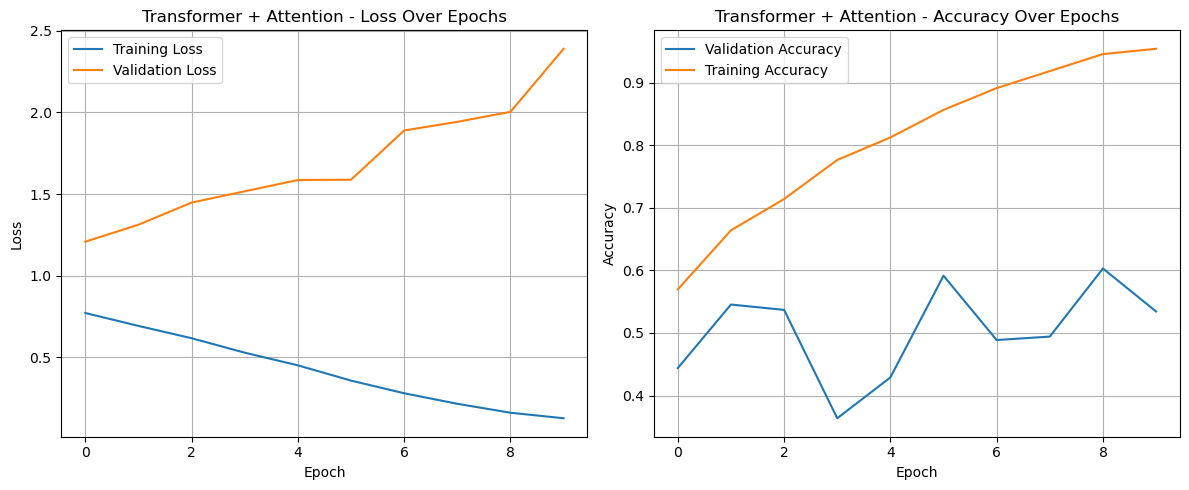

In [24]:
plot_single_model_history("LSTM", lstm_history)
plot_single_model_history("Attention", attn_history)
plot_single_model_history("LSTM + Attention", lstm_attn_history)
plot_single_model_history("Transformer + Attention", transformer_history)

## Improved model with Data remanipulation

In [26]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [27]:
from tqdm import tqdm
tqdm.pandas()

In [28]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [29]:
from collections import Counter

train_words = []
for i in train_data_pd['cleaned_text'].values:
    train_words += i.split()
all1 = train_words
all_train_words = set(train_words)

val_words = []
for i in val_data_pd['cleaned_text'].values:
    val_words += i.split()

all2 = val_words
all_val_words = set(val_words)

print("train all:", len(all1))
print("val all:", len(all2))
print("unique in train:", len(all_train_words))
print("unique in val:", len(all_val_words))

train all: 30784
val all: 26518
unique in train: 6538
unique in val: 5910


In [30]:
train_counter = Counter(all1)
val_counter = Counter(all2)

low_freq_words = set()

for word in all_unique_words:
    train_freq = train_counter.get(word, 0)
    val_freq = val_counter.get(word, 0)
    # print(f"Word '{word}': Training Frequency = {train_freq}, Validation Frequency = {val_freq}")
    
    if train_freq < 1:
        low_freq_words.add(word)
print("low freq or only in val:", len(low_freq_words))

low freq or only in val: 2717


In [31]:
def replace_low_freq(text, low_freq_set):

    words = text.split()
    
    new_words = []
    
    for word in words:
        if word in low_freq_set:
            new_words.append("unknown")
        else:
            new_words.append(word)
    
    new_text = " ".join(new_words)
    return new_text

In [32]:
def process_text(text):
    return replace_low_freq(text, low_freq_words)

train_data_pd['final_text'] = train_data_pd['cleaned_text'].apply(process_text)
val_data_pd['final_text'] = val_data_pd['cleaned_text'].apply(process_text)

/var/folders/n5/z8b12shx2ql9049prv6m9mwm0000gn/T/ipykernel_65935/3309353001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_pd['final_text'] = train_data_pd['cleaned_text'].apply(process_text)
/var/folders/n5/z8b12shx2ql9049prv6m9mwm0000gn/T/ipykernel_65935/3309353001.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data_pd['final_text'] = val_data_pd['cleaned_text'].apply(process_text)


In [33]:
def stem_text(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    stem = ''
    
    for i in x:
        stem += stemmer.stem(i) + ' '
        
    return stem
    
train_data_pd['cleaned_stemmed_review'] = train_data_pd['final_text'].progress_apply(stem_text)
val_data_pd['cleaned_stemmed_review'] = val_data_pd['final_text'].progress_apply(stem_text)

100%|█████████████████████████████████████| 2500/2500 [00:00<00:00, 4798.68it/s]
/var/folders/n5/z8b12shx2ql9049prv6m9mwm0000gn/T/ipykernel_65935/802831324.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_pd['cleaned_stemmed_review'] = train_data_pd['final_text'].progress_apply(stem_text)
100%|█████████████████████████████████████| 2345/2345 [00:00<00:00, 5440.71it/s]
/var/folders/n5/z8b12shx2ql9049prv6m9mwm0000gn/T/ipykernel_65935/802831324.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
!pip install librosa

In [35]:
new_words1 = []
for i in train_data_pd['cleaned_stemmed_review'].values:
    new_words1 += i.split()
nw1 = set(new_words1)
print('number of unique words: ', len(nw1))

new_words2 = []
for i in val_data_pd['cleaned_stemmed_review'].values:
    new_words2 += i.split()
nw2 = set(new_words2)
print('number of unique words: ', len(nw2))

nw3 = nw1 | nw2
word_to_index = {}
idx = 0
for word in nw3:
    word_to_index[word] = idx
    idx += 1

number of unique words:  5019
number of unique words:  2416


In [36]:
tc = Counter(new_words1)
vc = Counter(new_words2)

low_freq_words = set()

for word in nw3:
    train_freq = tc.get(word, 0)
    val_freq = vc.get(word, 0)
    # print(f"Word '{word}': Training Frequency = {train_freq}, Validation Frequency = {val_freq}")
    
    if train_freq < 1:
        low_freq_words.add(word)
print("low freq or only in val:", len(low_freq_words))

low freq or only in val: 1


In [37]:
train_dataset = text_dataset(train_data_pd['cleaned_stemmed_review'].values, train_data_pd['cleaned_label'].values, word_to_index)
val_dataset = text_dataset(val_data_pd['cleaned_stemmed_review'].values, val_data_pd['cleaned_label'].values, word_to_index)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [39]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, drop_out=0.2):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.net = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.embedding(x)             
        x = x.mean(dim=1)                
        out = self.net(x)                
        return out

In [40]:
N_EPOCHS = 10
embed_dim = 200
hidden_dim = 200
output_dim = 3
vocab_size = len(word_to_index)
number_of_class = len(label_map_dict)

In [41]:
model = MLP(vocab_size, embed_dim, hidden_dim, output_dim, drop_out=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [42]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == y_batch).sum().item()
        total   += y_batch.size(0)

    epoch_train_loss = running_loss / len(train_dataloader.dataset)
    epoch_train_acc  = 100.0 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    model.eval()
    running_loss_test = 0.0
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in train_dataloader:
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            running_loss_test += loss.item() * X_batch.size(0)

            _, predicted = torch.max(outputs, dim=1)
            correct_test += (predicted == y_batch).sum().item()
            total_test   += y_batch.size(0)

    epoch_test_loss = running_loss_test / len(val_dataloader.dataset)
    epoch_test_acc  = 100.0 * correct_test / total_test
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]"
          f" | Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%"
          f" | Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")

Epoch [1/10] | Train Loss: 0.7182, Train Acc: 63.44% | Test Loss: 0.4931, Test Acc: 81.20%
Epoch [2/10] | Train Loss: 0.4586, Train Acc: 80.68% | Test Loss: 0.2525, Test Acc: 92.16%
Epoch [3/10] | Train Loss: 0.2564, Train Acc: 89.72% | Test Loss: 0.1273, Test Acc: 96.44%
Epoch [4/10] | Train Loss: 0.1330, Train Acc: 95.44% | Test Loss: 0.0541, Test Acc: 98.88%
Epoch [5/10] | Train Loss: 0.0733, Train Acc: 98.04% | Test Loss: 0.0380, Test Acc: 99.24%
Epoch [6/10] | Train Loss: 0.0603, Train Acc: 98.24% | Test Loss: 0.0275, Test Acc: 99.32%
Epoch [7/10] | Train Loss: 0.0465, Train Acc: 98.60% | Test Loss: 0.0316, Test Acc: 99.00%
Epoch [8/10] | Train Loss: 0.0479, Train Acc: 98.44% | Test Loss: 0.0184, Test Acc: 99.44%
Epoch [9/10] | Train Loss: 0.0281, Train Acc: 99.20% | Test Loss: 0.0334, Test Acc: 99.16%
Epoch [10/10] | Train Loss: 0.0332, Train Acc: 98.96% | Test Loss: 0.0146, Test Acc: 99.40%


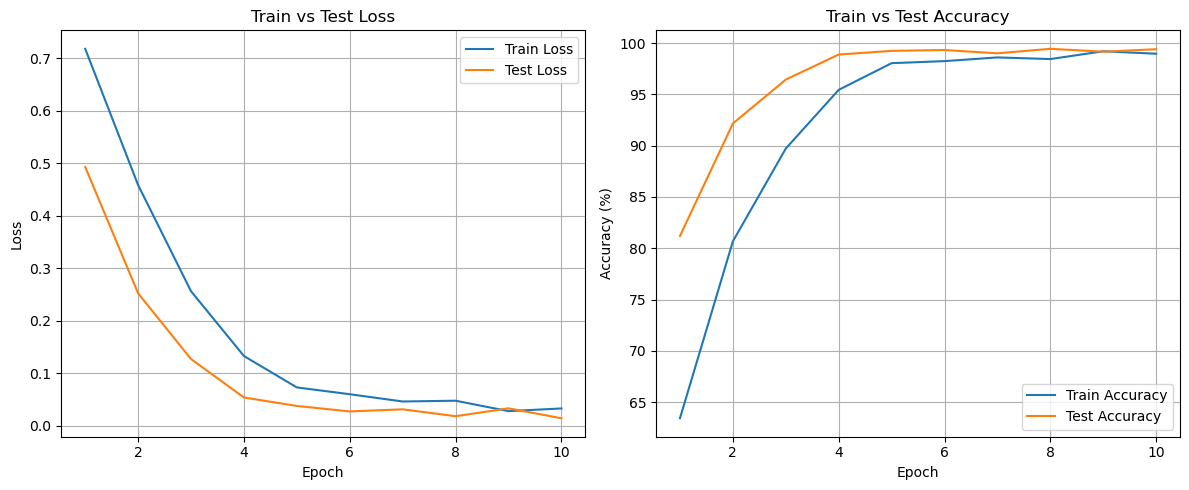

In [43]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()